 ## ImageCaptionRNN - 


### Importing

In [3]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from tensorflow.keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam

2023-05-11 00:51:19.605127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 00:51:20.516128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-11 00:51:20.516245: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

### Flickr8k data

Flickr8k data set, described here in more detail: 

M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results

The data used: https://storage.googleapis.com/4705-hw5-data/hw5data-20220809T182644Z-001.zip


In [4]:


! wget https://storage.googleapis.com/4705-hw5-data/hw5data-20220809T182644Z-001.zip    

--2023-05-11 00:51:21--  https://storage.googleapis.com/4705-hw5-data/hw5data-20220809T182644Z-001.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c0d::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1120506096 (1.0G) [application/zip]
Saving to: ‘hw5data-20220809T182644Z-001.zip.7’

hw5data-20220809T18 100%[===================>]   1.04G   208MB/s    in 4.9s    

2023-05-11 00:51:26 (217 MB/s) - ‘hw5data-20220809T182644Z-001.zip.7’ saved [1120506096/1120506096]



In [5]:
# Then unzip the data 
! unzip -n hw5data-20220809T182644Z-001.zip 

Archive:  hw5data-20220809T182644Z-001.zip


In [6]:
FLICKR_PATH="hw5data"

Image Encodings 

The files Flickr_8k.trainImages.txt Flickr_8k.devImages.txt Flickr_8k.testImages.txt, contain a list of training, development, and test images

In [161]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [162]:
train_list = load_image_list(os.path.join(FLICKR_PATH, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.devImages.txt'))
test_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.testImages.txt'))

number of images:

In [163]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [164]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [165]:
IMG_PATH = os.path.join(FLICKR_PATH, "Flickr8k_Dataset")

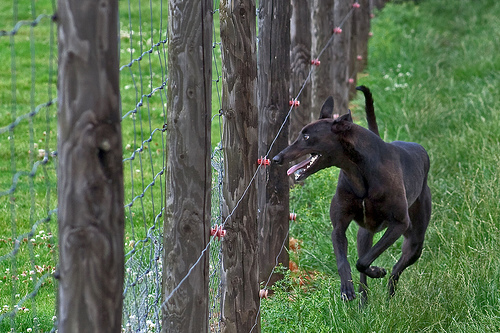

In [166]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

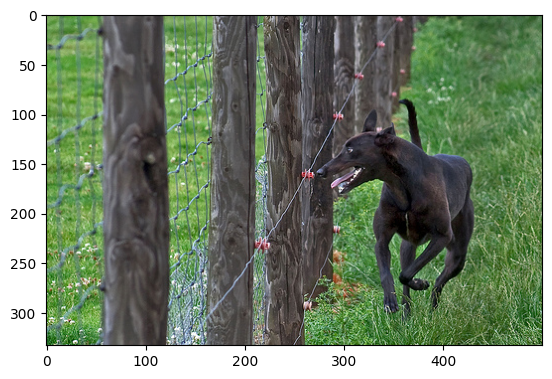

In [167]:
plt.imshow(image)

Using off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection.
-  input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [168]:
np.asarray(image).shape

(333, 500, 3)

The values range from 0 to 255. 

In [169]:
np.asarray(image)

array([[[118, 161,  89],
        [120, 164,  89],
        [111, 157,  82],
        ...,
        [ 68, 106,  65],
        [ 64, 102,  61],
        [ 65, 104,  60]],

       [[125, 168,  96],
        [121, 164,  92],
        [119, 165,  90],
        ...,
        [ 72, 115,  72],
        [ 65, 108,  65],
        [ 72, 115,  70]],

       [[129, 175, 102],
        [123, 169,  96],
        [115, 161,  88],
        ...,
        [ 88, 129,  87],
        [ 75, 116,  72],
        [ 75, 116,  72]],

       ...,

       [[ 41, 118,  46],
        [ 36, 113,  41],
        [ 45, 111,  49],
        ...,
        [ 23,  77,  15],
        [ 60, 114,  62],
        [ 19,  59,   0]],

       [[100, 158,  97],
        [ 38, 100,  37],
        [ 46, 117,  51],
        ...,
        [ 25,  54,   8],
        [ 88, 112,  76],
        [ 65, 106,  48]],

       [[ 89, 148,  84],
        [ 44, 112,  35],
        [ 71, 130,  72],
        ...,
        [152, 188, 142],
        [113, 151, 110],
        [ 94, 138,  75]]

We can use PIL to resize the image and then divide every value by 255. 

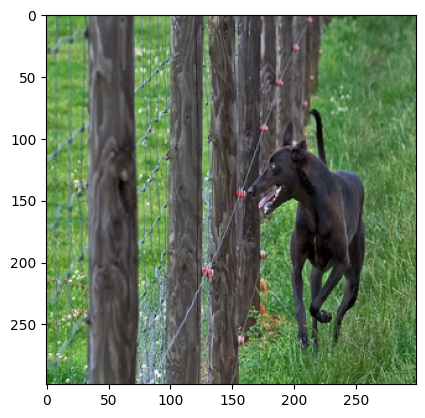

In [170]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [171]:
new_image.shape

(299, 299, 3)

In [172]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0                     

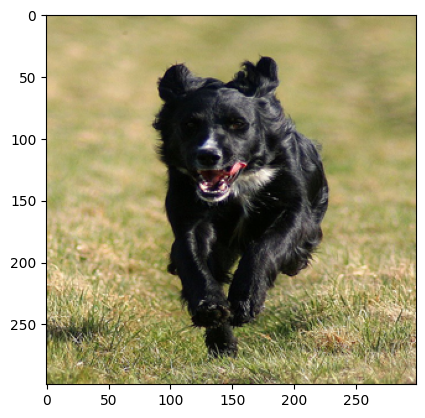

In [173]:
plt.imshow(get_image(dev_list[25]))

Loading the pre-trained Inception model. 

In [175]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.

In [176]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 149, 149, 32  864         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 149, 149, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                      

- This is a prediction model,so the output is  a softmax-activated vector representing 1000 possible object types.
- Interested in an encoded representation of the image  -> using the second-to-last layer as a source of image encodings.\
-  Each image will be encoded as a vector of size 2048. 
- Hooking up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [22]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) 

In [23]:
encoded_image = img_encoder.predict(np.array([new_image]))

2023-05-11 00:51:36.280744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200


1/1 [==============================] - 4s 4s/step


In [24]:
encoded_image

array([[0.6380648 , 0.48877823, 0.05527429, ..., 0.6425622 , 0.2959566 ,
        0.4900241 ]], dtype=float32)

This is generator function, which should return one image at a time. 
- `img_list` is a list of image file names (i.e. the train, dev, or test set).
-  The return value is a numpy array of shape (1,299,299,3).

In [25]:
def img_generator(img_list):
    index = 0 
    while index < len(img_list):
        image_representation = get_image(img_list[index])
        yield image_representation.reshape((1,299,299,3))
        index += 1 

# Encoding Images

In [26]:
enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


6000/6000 [==============================] - 106s 17ms/step


In [27]:
enc_train[11]

array([0.2682099 , 1.0321503 , 0.58516306, ..., 1.2316765 , 0.17968386,
       0.22405392], dtype=float32)

In [28]:
enc_dev = img_encoder.predict_generator(img_generator(dev_list), steps=len(dev_list), verbose=1)

   4/1000 [..............................] - ETA: 21s

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


1000/1000 [==============================] - 17s 17ms/step


In [29]:
enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)

   8/1000 [..............................] - ETA: 16s

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


1000/1000 [==============================] - 18s 18ms/step


In [30]:
# Choose a suitable location here, please do NOT attempt to write your output files to the shared data directory. 
OUTPUT_PATH = "hw5output" 
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

In [31]:
np.save(os.path.join(OUTPUT_PATH,"encoded_images_train.npy"), enc_train)
np.save(os.path.join(OUTPUT_PATH,"encoded_images_dev.npy"), enc_dev)
np.save(os.path.join(OUTPUT_PATH,"encoded_images_test.npy"), enc_test)

##  Text (Caption) Data Preparation



### Reading image descriptions

This function  reads  image descriptions from the file `filename` and returns a dictionary

In [32]:
def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)
    loaded_file = load_image_list(filename)

    for entry in loaded_file:
        split_entry = entry.strip().split()
        image_id = split_entry[0].split('#')[0]
        caption = split_entry[1:]
        caption = [word.lower() for word in caption]
        caption = ['<START>'] + caption + ['<END>']
        image_descriptions[image_id].append(caption)
    return image_descriptions

In [33]:
descriptions = read_image_descriptions(f"{FLICKR_PATH}/Flickr8k.token.txt")

In [34]:
print(descriptions[dev_list[0]])

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


Running the previous cell should print:     
`[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]
`    

### Creating Word Indices

- lookup table from the **training** data mapping words to integer indices, to encode input 
and output sequences using numeric representations. 
- its the dictionaries id_to_word and word_to_id, which  map tokens to numeric ids and numeric ids to tokens.  
 

In [35]:
all_words = [word for captions in descriptions.values() for caption in captions for word in caption]

unique_words = sorted(list(set(all_words)))

id_to_word = {i: word for i, word in enumerate(unique_words)}

In [36]:
word_to_id = {word: i for i, word in id_to_word.items()}

In [37]:
word_to_id['dog'] 

2309

In [38]:
id_to_word[1985]

'crucified'

##  Basic Decoder Model

- Training a model for text generation without conditioning the generator on the image input. 
- The model will predict one word at a time, given a partial sequence. Given the sequence ["START","a"], the model might predict "dog" as the most likely word. 
-  using the LSTM to encode the input sequence up to this point. 
- Bidirectional LSTM is utilized, which encodes the sequence from both directions

In [39]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

40


<img src="http://www.cs.columbia.edu/~bauer/4705/lstm2.png" width="480px">


- The model input ---  a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. 
- E]ach row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary)

In [69]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 40, 300)           2676000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 1024)             3330048   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 8920)              9143000   
                                                                 
Total params: 15,149,048
Trainable params: 15,149,048
Non-trainable params: 0
_________________________________________________________________


### Creating a Generator for the Training Data

- Creatde one large numpy ndarray for all the training data though batches using a generator (recall the image generator in part I). 
-  function `text_training_generator`  takes as a paramater the batch_size and returns an `(input, output)` pair. 
- `input` is a `(batch_size, MAX_LEN)` ndarray of partial input sequences,
-  `output` contains the next words predicted for each partial input sequence, encoded as a `(batch_size, vocab_size)` ndarray.

 


In [70]:
def text_training_generator(batch_size=128):
    input_sequences = np.zeros((batch_size, MAX_LEN))
    output_words = np.zeros((batch_size, vocab_size))

    batch_index = 0
    while True:
        np.random.shuffle(train_list)

        for image_id in train_list:
            for desc in descriptions[image_id]:
                for i in range(len(desc) - 1):
                    input_seq = [word_to_id[word] for word in desc[:i+1]]
                    input_seq += [0] * (MAX_LEN - len(input_seq))
                    output_seq = np.zeros(vocab_size)
                    output_seq[word_to_id[desc[i+1]]] = 1

                    input_sequences[batch_index] = np.array(input_seq)
                    output_words[batch_index] = output_seq

                    batch_index += 1
                    if batch_index == batch_size:
                        yield [input_sequences, output_words]
                        input_sequences = np.zeros((batch_size, MAX_LEN))
                        output_words = np.zeros((batch_size, vocab_size))
                        batch_index = 0



### Training the Model

`fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.

Because there are len(train_list) training samples with up to `MAX_LEN` words, an upper bound for the number of total training instances is `len(train_list)*MAX_LEN`. Because the generator returns these in batches, the number of steps is len(train_list) * MAX_LEN // batch_size

In [71]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [72]:
model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=13)

Epoch 1/13


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


1875/1875 [==============================] - 96s 49ms/step - loss: 4.6076 - accuracy: 0.2542
Epoch 2/13
1875/1875 [==============================] - 89s 48ms/step - loss: 3.8708 - accuracy: 0.3339
Epoch 3/13
1875/1875 [==============================] - 89s 48ms/step - loss: 3.7071 - accuracy: 0.3496
Epoch 4/13
1875/1875 [==============================] - 89s 47ms/step - loss: 3.5773 - accuracy: 0.3624
Epoch 5/13
1875/1875 [==============================] - 89s 48ms/step - loss: 3.5049 - accuracy: 0.3706
Epoch 6/13
1875/1875 [==============================] - 89s 48ms/step - loss: 3.4422 - accuracy: 0.3751
Epoch 7/13
1875/1875 [==============================] - 90s 48ms/step - loss: 3.3761 - accuracy: 0.3844
Epoch 8/13
1875/1875 [==============================] - 89s 47ms/step - loss: 3.3477 - accuracy: 0.3848
Epoch 9/13
1875/1875 [==============================] - 89s 48ms/step - loss: 3.2636 - accuracy: 0.3923
Epoch 10/13
1875/1875 [==============================] - 89s 48ms/step - lo

Continue to train the model until you reach an accuracy of at least 40%. 

### Greedy Decoder

- it starts with the sequence `["<START>"]`, uses the model to predict the most likely word, 
- it appends the word to the sequence and then continue until `"<END>"` is predicted 
- or the sequence reaches `MAX_LEN` words. 

In [77]:
def decoder():
    output_seq = ["<START>"]
    numeric_seq = np.zeros(MAX_LEN, dtype=int)
    i = 0
    
    while i < MAX_LEN:
        numeric_seq[:len(output_seq)] = [word_to_id[w] for w in output_seq]
        out_probs = model.predict(np.expand_dims(numeric_seq, axis=0))[0]
        
        maximm_idx = np.argmax(out_probs)
        next_word = id_to_word[maximm_idx]
        output_seq.append(next_word)
        i += 1 
        if next_word == "<END>" or i == MAX_LEN:
            break    
    return output_seq



In [78]:
print(decoder())

1/1 [==============================] - 0s 22ms/step
['<START>', 'a', 'child', 'in', 'a', 'blue', 'shirt', 'is', 'riding', 'a', 'bike', 'in', 'a', 'park', '.', '<END>']


In [79]:
def sample_decoder():
    output_seq = ["<START>"]
    numeric_seq = np.zeros(MAX_LEN, dtype=int)
    i = 0
    
    while i < MAX_LEN and output_seq[-1] != "<END>":
        numeric_seq[:len(output_seq)] = [word_to_id[w] for w in output_seq]
        out_probs = model.predict(np.expand_dims(numeric_seq, axis=0))[0]
        #normalizing with 1e-6
        out_probs /= np.sum(out_probs) + 1e-6 
        next_word_id = np.random.multinomial(1, out_probs).argmax()
        next_word = id_to_word[next_word_id]
        
        output_seq.append(next_word)
        i += 1 
        
        if next_word == "<END>" or i == MAX_LEN:
            break
    
    return output_seq



In [80]:
for i in range(10): 
    print(sample_decoder())

1/1 [==============================] - 0s 23ms/step
['<START>', 'a', 'man', 'in', 'tan', 'pants', 'walking', 'in', 'the', 'snow', '.', '<END>']
1/1 [==============================] - 0s 22ms/step
['<START>', 'a', 'small', 'metallic', 'man', ',', 'wearing', 'sells', 'clothes', 'and', 'japanese', 'crazy', 'casket', 'climbing', 'on', 'a', 'football', 'riding', '.', '<END>']
1/1 [==============================] - 0s 23ms/step
['<START>', 'three', 'boys', 'with', 'its', 'headlight', 'harnessed', 'walk', 'in', 'field', 'of', 'froup', '.', '<END>']
1/1 [==============================] - 0s 23ms/step
['<START>', 'little', 'boys', 'are', 'looking', 'at', 'something', 'in', 'a', 'frolics', 'holding', 'development', 'and', 'curving', '.', '<END>']
1/1 [==============================] - 0s 25ms/step
['<START>', 'a', 'child', 'face-paint', 'his', 'book', 'running', 'in', 'the', 'snow', '.', '<END>']
1/1 [==============================] - 0s 23ms/step
['<START>', 'a', 'little', 'tattered', 'blue-gra

##  Conditioning on the Image 

-extending the model to condition the next word not only on the partial sequence, but also on the encoded image. 

In [208]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 300)          614700      ['input_22[0][0]']               
                                                                                                  
 input_23 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector_8 (RepeatVector)  (None, 40, 300)     0           ['dense_18[0][0]']               
                                                                                           

In [209]:
enc_train = np.load(f"{OUTPUT_PATH}/encoded_images_train.npy")
enc_dev = np.load(f"{OUTPUT_PATH}/encoded_images_dev.npy")

In [210]:
def training_generator(batch_size=128):
    image_input_data = []
    text_input_data = []
    next_word_data = []

    while True:
        for idx, img_id in enumerate(train_list):
            encoded_img = enc_train[idx]
            for d in descriptions[img_id]:
                for i in range(len(d) - 1):
                    # one-hot encoded representation
                    next_word = d[i + 1]
                    next_word_one_hot = to_categorical(word_to_id[next_word], vocab_size)

                    part_d = d[:i + 1]
                    part_s = np.zeros(MAX_LEN)
                    for j, word in enumerate(part_d):
                        part_s[j] = word_to_id[word]
                    image_input_data.append(encoded_img)
                    text_input_data.append(part_s)
                    next_word_data.append(next_word_one_hot)

                    if len(text_input_data) == batch_size:
                        image_input_data = np.asarray(image_input_data)
                        text_input_data = np.asarray(text_input_data)
                        next_word_data = np.asarray(next_word_data)
                        yield ([image_input_data, text_input_data], next_word_data)
                        image_input_data = []
                        text_input_data = []
                        next_word_data = []

        if image_input_data:
            image_input_data = np.asarray(image_input_data)
            text_input_data = np.asarray(text_input_data)
            next_word_data = np.asarray(next_word_data)
            yield ([image_input_data, text_input_data], next_word_data)
            image_input_data = []
            text_input_data = []
            next_word_data = []



In [211]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

In [212]:
model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=20)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


1875/1875 [==============================] - 62s 31ms/step - loss: 5.3230 - accuracy: 0.1175
Epoch 2/20
1875/1875 [==============================] - 55s 29ms/step - loss: 5.1960 - accuracy: 0.1194
Epoch 3/20
1875/1875 [==============================] - 55s 29ms/step - loss: 5.1630 - accuracy: 0.1184
Epoch 4/20
1875/1875 [==============================] - 55s 29ms/step - loss: 5.1411 - accuracy: 0.1254
Epoch 5/20
1875/1875 [==============================] - 55s 29ms/step - loss: 4.8420 - accuracy: 0.2155
Epoch 6/20
1875/1875 [==============================] - 55s 29ms/step - loss: 4.6356 - accuracy: 0.2321
Epoch 7/20
1875/1875 [==============================] - 55s 29ms/step - loss: 4.5192 - accuracy: 0.2576
Epoch 8/20
1875/1875 [==============================] - 55s 29ms/step - loss: 4.2281 - accuracy: 0.3000
Epoch 9/20
1875/1875 [==============================] - 55s 29ms/step - loss: 3.9536 - accuracy: 0.3302
Epoch 10/20
1875/1875 [==============================] - 55s 29ms/step - lo

KeyboardInterrupt: 

In [213]:
model.save_weights(f"{OUTPUT_PATH}/model.h5")

In [214]:
model.load_weights(f"{OUTPUT_PATH}/model.h5")

## RESUlTS: Generate image captions 
-  Modified  simple greedy decoder used in the text-only generator, 
- it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

In [215]:
def img_decoder(enc_image):
    start_token = word_to_id['<START>']
    end_token = word_to_id['<END>']
    input_text = np.array([start_token])
    generated_sequence = []

    for _ in range(MAX_LEN):
        # Padding the input_text to have length MAX_LEN
        input_text_padded = np.pad(input_text, (0, MAX_LEN - len(input_text)), mode='constant')
        
        preds = model.predict([enc_image.reshape(1, -1), input_text_padded.reshape(1, -1)], verbose=0)
        predicted_word_id = np.argmax(preds)
        if predicted_word_id == end_token:
            break
        generated_sequence.append(id_to_word[predicted_word_id])
        input_text = np.append(input_text, predicted_word_id)
    return ' '.join(generated_sequence)


In [216]:
def img_decoder(enc_image): 
    sent = ['<START>']
    sent_numeric = np.zeros(MAX_LEN)
    i = 0
    while i < MAX_LEN and sent[-1] != '<END>':
        sent_numeric[i] = word_to_id[sent[i]]
        out = model.predict([ np.array([enc_image]), np.array([sent_numeric]) ])
        max_idx = np.argmax(out[0])
        sent.append(id_to_word[max_idx])
        i += 1
        
    return sent

As a sanity check, you should now be able to reproduce (approximately) captions for the training images. 

1/1 [==============================] - 0s 23ms/step


['<START>', 'two', 'dogs', 'play', 'in', 'the', 'snow', '.', '<END>']

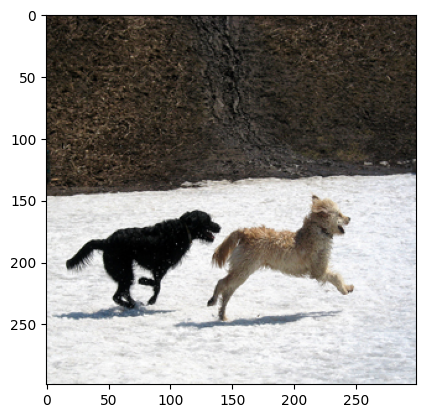

In [217]:
plt.imshow(get_image(train_list[0]))
img_decoder(enc_train[0])

1/1 [==============================] - 0s 24ms/step


['<START>',
 'a',
 'man',
 'in',
 'a',
 'black',
 'shirt',
 'is',
 'jumping',
 'over',
 'a',
 'park',
 '.',
 '<END>']

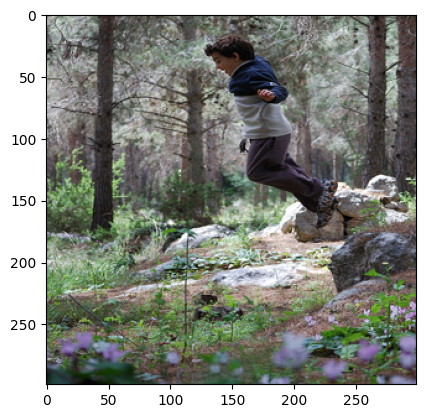

In [218]:
plt.imshow(get_image(dev_list[1]))
img_decoder(enc_dev[0])

For this assignment we will not perform a formal evaluation. 

Feel free to experiment with the parameters of the model or continue training the model. At some point, the model will overfit and will no longer produce good descriptions for the dev images. 

##  Beam Search Decoder 

In [248]:
def img_beam_decoder(n, encoded_image):
    start_token = word_to_id['<START>']
    end_token = word_to_id['<END>']
    current_seqs = [(1.0, [start_token])]

    def get_next_candidates(current_seqs, encoded_image, n):
        next_candidates = []
        for score, seq in current_seqs:
            last_word_id = seq[-1]
            if last_word_id == end_token or len(seq) >= MAX_LEN:
                next_candidates.append((score, seq))
                continue

            seq_padded = pad_sequences([seq], maxlen=MAX_LEN, padding='post', value=0)
            encoded_image = np.asarray([encoded_image]).reshape((1, 2048))
            seq_padded = np.asarray([seq_padded]).reshape((1, MAX_LEN))
            preds = model.predict([encoded_image, seq_padded])[0]
            top_indices = preds.argsort()[-n:]

            for index in top_indices:
                candidate_seq = seq[:]
                candidate_seq.append(index)
                candidate_score = score * preds[index]
                next_candidates.append((candidate_score, candidate_seq))

        return sorted(next_candidates, key=lambda tup: tup[0], reverse=True)[:n]

    while True:
        next_candidates = get_next_candidates(current_seqs, encoded_image, n)
        current_seqs = next_candidates
        if current_seqs[0][1][-1] == end_token or len(current_seqs[0][1]) >= MAX_LEN:
            break

    best_sequence = current_seqs[0][1]
    best_caption = [id_to_word[word_id] for word_id in best_sequence]
    return ' '.join(best_caption)








1/1 [==============================] - 0s 23ms/step
<START> a person in a blue shirt is jumping down a dirt hill . <END>


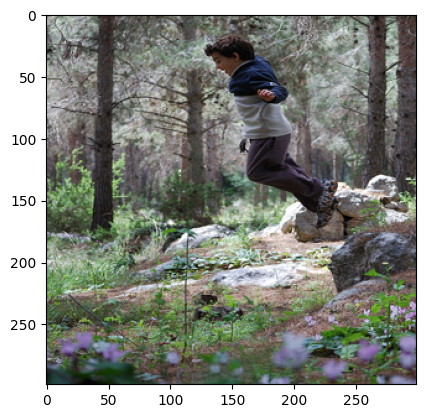

In [249]:
plt.imshow(get_image(dev_list[1]))
print(img_beam_decoder(3, enc_dev[1]))

## Result: Greedy Output, beam search at n=3 and beam search at n=5. 

1/1 [==============================] - 0s 26ms/step
Greedy:  ['<START>', 'a', 'woman', 'in', 'a', 'red', 'shirt', 'is', 'holding', 'a', 'woman', 'in', 'a', 'red', 'shirt', '.', '<END>']
1/1 [==============================] - 0s 25ms/step
Beam n=3:  <START> a woman in a red shirt is holding a woman in front of a woman . <END>
1/1 [==============================] - 0s 24ms/step
Beam n=5:  <START> a young girl in a red shirt is holding a camera . <END>


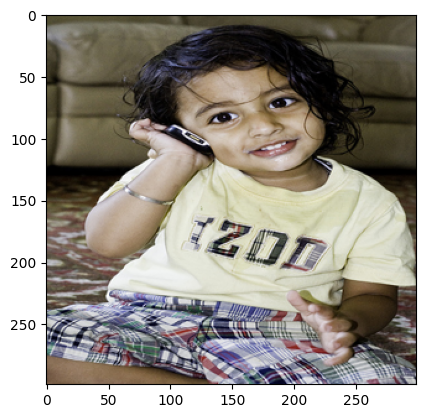

In [250]:
pic = 717
plt.imshow(get_image(dev_list[pic]))
print('Greedy: ', image_decoder(enc_dev[pic]))
print('Beam n=3: ', img_beam_decoder(3, enc_dev[pic]))
print('Beam n=5: ', img_beam_decoder(5, enc_dev[pic]))

1/1 [==============================] - 0s 27ms/step
Greedy:  ['<START>', 'a', 'little', 'boy', 'is', 'sitting', 'on', 'a', 'red', 'toy', 'with', 'a', 'toy', '.', '<END>']
1/1 [==============================] - 0s 25ms/step
Beam n=3:  <START> a little boy in a red shirt is sitting on a red toy . <END>
1/1 [==============================] - 0s 23ms/step
Beam n=5:  <START> a little boy in a red shirt is sitting on a red toy . <END>


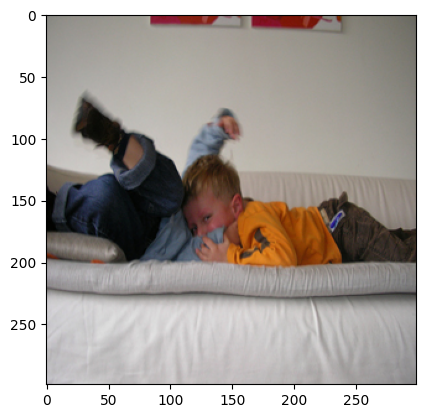

In [253]:
pic = 314
plt.imshow(get_image(dev_list[pic]))
print('Greedy: ', image_decoder(enc_dev[pic]))
print('Beam n=3: ', img_beam_decoder(3, enc_dev[pic]))
print('Beam n=5: ', img_beam_decoder(5, enc_dev[pic]))

1/1 [==============================] - 0s 24ms/step
Greedy:  ['<START>', 'a', 'woman', 'in', 'a', 'black', 'shirt', 'and', 'a', 'woman', 'are', 'sitting', 'on', 'a', 'woman', 'in', 'a', 'red', 'shirt', '.', '<END>']
1/1 [==============================] - 0s 25ms/step
Beam n=3:  <START> a woman in a black shirt and a woman are sitting in front of a woman . <END>
1/1 [==============================] - 0s 23ms/step
Beam n=5:  <START> a woman in a black shirt and a woman are sitting in front of a woman . <END>


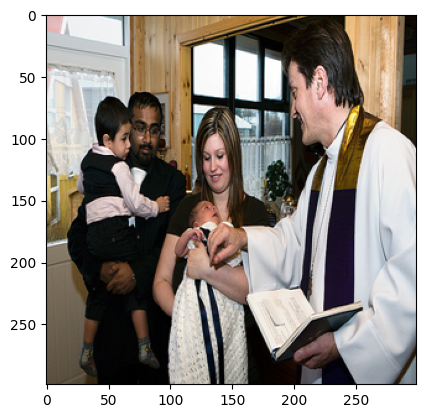

In [254]:
pic = 23
plt.imshow(get_image(dev_list[pic]))
print('Greedy: ', image_decoder(enc_dev[pic]))
print('Beam n=3: ', img_beam_decoder(3, enc_dev[pic]))
print('Beam n=5: ', img_beam_decoder(5, enc_dev[pic]))

1/1 [==============================] - 0s 23ms/step
Greedy:  ['<START>', 'a', 'small', 'dog', 'is', 'running', 'on', 'a', 'field', '.', '<END>']
1/1 [==============================] - 0s 30ms/step
Beam n=3:  <START> two dogs run on a grassy field . <END>
1/1 [==============================] - 0s 27ms/step
Beam n=5:  <START> a brown and white dog runs on a field . <END>


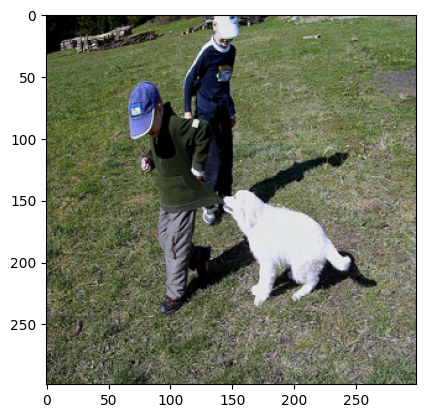

In [252]:
pic = 666
plt.imshow(get_image(dev_list[pic]))
print('Greedy: ', image_decoder(enc_dev[pic]))
print('Beam n=3: ', img_beam_decoder(3, enc_dev[pic]))
print('Beam n=5: ', img_beam_decoder(5, enc_dev[pic]))

1/1 [==============================] - 0s 23ms/step
Greedy:  ['<START>', 'two', 'people', 'are', 'playing', 'in', 'the', 'water', '.', '<END>']
1/1 [==============================] - 0s 24ms/step
Beam n=3:  <START> two people are playing in the water . <END>
1/1 [==============================] - 0s 24ms/step
Beam n=5:  <START> two people play in the water . <END>


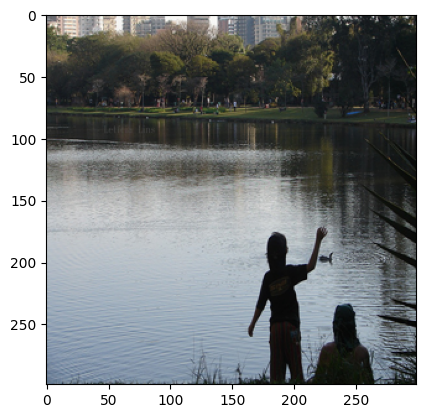

In [255]:
pic = 114
plt.imshow(get_image(dev_list[pic]))
print('Greedy: ', image_decoder(enc_dev[pic]))
print('Beam n=3: ', img_beam_decoder(3, enc_dev[pic]))
print('Beam n=5: ', img_beam_decoder(5, enc_dev[pic]))